In [1]:
from IPython.display import display, Image

# CNTK 103: Part D - Convolutional Neural Network with MNIST

We assume that you have successfully completed CNTK 103 Part A (MNIST Data Loader).

In this tutorial we will train a Convolutional Neural Network (CNN) on MNIST data. This notebook provides the recipe using Python APIs. If you are looking for this example in BrainScript, please look [here](https://github.com/Microsoft/CNTK/tree/v2.0.rc2/Examples/Image/GettingStarted)

## Introduction

As summarized in Wikipedia, a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN, or ConvNet) is a type of [feed-forward](https://en.wikipedia.org/wiki/Feedforward_neural_network) artificial neural network in which the connectivity pattern between its neurons is inspired by the organization of animal [visual cortex](https://en.wikipedia.org/wiki/Visual_cortex) (such as [Hubel and Wiesel model](http://knowingneurons.com/2014/10/29/hubel-and-wiesel-the-neural-basis-of-visual-perception/)) of the brain's visual cortex. The cells in visual cortex emit responses when stimulated. This region is known as the **receptive fields (RF)**, where each receptive-field overlapping with one another come together to generate the visual field (or image). This model views the mammalian visual cortex as a set of hierarchical layers, each consisting of simple cells that extract features from a localized area and complex cells that take their input from multiple simple cells. Popular deep CNNs or ConvNets (such as [AlexNet](https://en.wikipedia.org/wiki/AlexNet), [VGG](https://arxiv.org/abs/1409.1556), [Inception](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf), [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf)) that are used for various [computer vision](https://en.wikipedia.org/wiki/Computer_vision) tasks have many of these architectural primitives (inspired from biology). 

The [convolution](https://en.wikipedia.org/wiki/Kernel_(image_processing)) operation closely approximates how we see and visually interpret the world around us. The convolution networks (a variation of the MLP network) are optimized feed-forward operations. In this tutorial, we will introduce the convolution operation and gain familiarity with the different parameters in CNNs.  

**Problem**:
As in CNTK 103C, we will continue to work on the same problem of recognizing digits in MNIST data. The MNIST data comprises of hand-written digits with little background noise.

In [2]:
# Figure 1
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

**Goal**:
Our goal is to train a classifier that will identify the digits in the MNIST dataset. 

**Approach**:

The same 5 stages we have used in the previous tutorial are applicable: Data reading, Data preprocessing, Creating a model, Learning the model parameters and Evaluating (a.k.a. testing/prediction) the model. 
- Data reading: We will use the CNTK Text reader 
- Data preprocessing: Covered in part A (suggested extension section). 

In this tutuorial, we will experiment with two models with different architechtural components.

In [3]:
# Import the relevant components
# Use a function definition from future version 
# (say 3.x while running 2.7 interpreter)
from __future__ import print_function
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C

# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

%matplotlib inline

## Data reading

In this section, we will read the data generated in CNTK 103 Part A (MNIST Data Loader).

We are using the MNIST data that you have downloaded using the CNTK_103A_MNIST_DataLoader notebook. The dataset has 60,000 training images and 10,000 test images with each image being 28 x 28 pixels. Thus the number of features is equal to 784 (= 28 x 28 pixels), 1 per pixel. The variable `num_output_classes` is set to 10 corresponding to the number of digits (0-9) in the dataset.


In the past tutorials, we have always flattened the input image into a vector.

![MNIST-flat](https://www.cntk.ai/jup/cntk103a_MNIST_input.png)

**Input Dimensions**:  In convolutional networks for images, the input data is often shaped as a 3D matrix (one each for image width, height, number of channels), which preserves the spatial relationship between the pixels.
The number of channel dimension of the matrix can represent color channel (RGB), multiple video frames, etc.  In our MNIST data, the values are a single color channel (grayscale), so our depth dimension is = 1. Note, if one has input data say a volumetric scan say with width, height and depth representing the 3 axes, the input data format would be specified by a tuple of 4 values (number of channels, width, height, depth). In this way CNTK enables specification of input images in N-dimensional space.

In [4]:
# Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the data dimensions
input_dim_model = (1, 28, 28)    # images are 28 x 28 with 1 channel of color (gray)
input_dim = 28*28                # used by readers to treat input data as a vector
num_output_classes = 10

**Data Format** The data is stored on our local machine in the CNTK CTF format.  The CTF format is a simple text format that contains a set of samples with each sample containing a set of named fields and their data.  For our MNIST data, each sample contains 2 fields: labels and feature, formatted as:

    |labels 0 0 0 0 0 0 0 1 0 0 |features 0 255 0 123 ... 
                                                  (784 integers each representing a pixel gray level)
    
In this tutorial we are going to use the image pixels corresponding to the integer stream named "features". We define a `create_reader` function to read the training and test data using the [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html#cntk.io.CTFDeserializer). The labels are [1-hot encoded](https://en.wikipedia.org/wiki/One-hot). 

When reading the data, the reader automatically maps the 784 pixels per image to a shape defined by `input_dim_model` variable.

In [5]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    ctf=C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [6]:
# Ensure the training and test data is available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.

data_found=False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    
    train_file=os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file=os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
    
print("Data directory is {0}".format(data_dir))

Data directory is ..\Examples\Image\DataSets\MNIST


<a id='#Model Creation'></a>
## CNN Model Creation

CNN is a feedforward network made up of bunch of layers in such a way that the output of one layer becomes the input to the next layer (similar to MLP). In MLP, all possible pairs of input pixels are connected to the output nodes with each pair having a weight, thus leading to an explosion of parameters to be learnt and also increasing the possibility of overfitting ([details](http://cs231n.github.io/neural-networks-1/). Convolution layers take advantage of the spatial arrangement of the pixels and learn multiple filters that significantly reduce the amount of parameters in the network(for [details](http://cs231n.github.io/convolutional-networks/)). The size of the filter is a parameter of the convolution layer and it spatial dimension corresponds to the receptive field (image pixels) in the input image (as explained below).  

In this section, we introduce the basics of convolution operations. We show the illustrations in the context of RGB images (3 channels), eventhough the MNIST data we are using in this tutorial is a grayscale image (single channel).

![input-rgb](https://www.cntk.ai/jup/cntk103d_rgb.png)

**Convolution Layers** A convolution layer is a set of feedforward Neural Network nodes (with weights (**W**), bias ($\vec{b}$), and an activation function) and $\vec{x}^T$ representing the input pixels corresponding to the weights matrix shape in the image (refer to the figure below). 

![input-filter](https://www.cntk.ai/jup/cntk103d_filterset.png)

They incorporate 3 key features:

   1. Instead of being fully-connected to all pairs of input and output nodes , each convolution node is **locally-connected** to a subset of input nodes localized to a smaller input region, also referred to as receptive field (RF). The figure above illustrates a small 3 x 3 regions in the image as the RF region. In the case of an RGB, image there would be three such 3 x 3 regions, one each of the 3 color channels. 
   
   2. Instead of having a single set of weights (as in a Dense layer), convolutional layers have multiple sets (shown in figure with multiple colors), called **filters**. Each filter detects features within each possible RF in the input image.  The output of the convolution is a set of `n` sub-layers (shown in the animation below) where `n` is the number of filters (refer to the above figure).    
     
   3. Within a sublayer, instead of each node having its own set of weights, a single set of **shared weights** are used by all nodes in that sublayer. This reduces the number of parameters to be learnt and thus overfitting. This also opens the door for several aspects of deep learning which has enabled very practical solutions to be built:
    - Handling larger images (say 512 x 512)
    - Trying larger filter sizes (corresponding to a larger RF) say 11 x 11
    - Learning more filters (say 128)
    - Explore deeper architectures (100+ layers)
    - Achieve translation invariance (the ability to recognize a feature independent of where they appear in the image). 
    
Here is an animation of the entire sequence of the convolution operation.

In [7]:
Image(url="https://www.cntk.ai/jup/cntk103d_conv2d_final.gif", width= 300)

**How are filters positioned?** In general, the filters are arranged in overlapping tiles, from left to right, and top to bottom.  Each convolution layer has a parameter to specify the `filter_shape`, specifying the width and height of the filter in case most natural scene images.  There is a parameter (`strides`) that controls the how far to step to right when moving the filters through multiple RF's in a row, and how far to step down when moving to the next row.  The boolean parameter `pad` controls if the input should be padded around the edges to allow a complete titling of the RF's near the borders. 

The animation above shows the results with a `filter_shape`=(3, 3), `strides`=(2, 2) and `pad`=False. The two animations below show the results when `pad` is set to True. First, with a stride of 2 and second having a stride of 1.
Note: the shape of the output (the teal layer) is different between the two stride settings. Many a times your decision to pad and the stride values to choose are based on the shape of the output layer needed.

In [8]:
# Plot images with strides of 2 and 1 with padding turned on
images=[("https://www.cntk.ai/jup/cntk103d_padding_strides.gif" , 'With stride = 2'),
        ("https://www.cntk.ai/jup/cntk103d_same_padding_no_strides.gif", 'With stride = 1')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=200, height=200))

With stride = 2


With stride = 1


**Pooling Layer** Often a times, one needs to control the number of parameters especially when having deep networks. For every layer of the convolution layer output (each layer, corresponds to the output of a filter), one can have a pooling layer. Pooling layers are typically introduced to:
- Reduce the dimensionality of the previous layer, which speed up the network.
- Provide a limited translation invariant.

The calculation on a pooling node is much simpler than a normal feedforward node.  It has no weight, bias, or activation function.  It uses a simple aggregation function (like max or average) to compute its output.  The most commonly used function is "max" - a max pooling node simply outputs the maximum of the input values (RF values) corresponding to the filter position of the input. Another alternative is average pooling, which emits that average value instead of the maximum value. Both these values are illustrated below.

In [9]:
# Plot images with strides of 2 and 1 with padding turned on
images = [("https://www.cntk.ai/jup/c103d_max_pooling.gif" , 'Max pooling'),
          ("https://www.cntk.ai/jup/c103d_average_pooling.gif", 'Average pooling')]

for im in images:
    print(im[1])
    display(Image(url=im[0], width=200, height=200))

Max pooling


Average pooling


**How to control shapes / parameters**?

## Basic convolution network

A typical CNN is a feedforward network that contains a set of alternating convolution (orange blocks) and pooling layers(blue block) followed by a dense output layer (green block) for classification.  This is in contrast to the MLP network we used in CNTK_103C, which consisted of 2 dense layers followed by a dense output layer.  

![mnist-cnn-5](https://www.cntk.ai/jup/cntk103d_MNIST-CNN-5.png)

The illustrations are presented in the context of 2-dimensional (2D) images, but the concept and the CNTK components can operate on any dimensional data. The above schematic shows 2 convolution layer and 2 max-pooling layers. A typical strategy is to increase the number of filters in the deeper layers while reducing the spatial size of each intermediate layers. intermediate layers.

## Building our CNN models

In this CNN tutorial, we first define two containers. One for the input MNIST image and the second one being the labels corresponding to the 10 digits. 

In [10]:
x=C.input(input_dim_model)
y=C.input(num_output_classes)

The first model we build is a simple convolution only network. This will help us understand how the convolution operations work and they perform in classifying MNIST images. The following figure illustrates the model we are going to build.

![conv-only](https://www.cntk.ai/jup/cntk103d_convonly.png)

In [11]:
# function to build model

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
            h=features
            h=C.layers.Convolution2D(filter_shape=(5,5), 
                                     num_filters=8, 
                                     strides=(2,2), 
                                     pad=True, name='first_conv')(h)
            h=C.layers.Convolution2D(filter_shape=(5,5), 
                                     num_filters=16, 
                                     strides=(2,2), 
                                     pad=True, name='second_conv')(h)
            r=C.layers.Dense(num_output_classes, activation = None, name='classify')(h)
            return r

Let us create an instance of the model and inspect the different components of the model. `z` will be used to represent the output of a network. In this model, we use the `relu` activation function. Note: using the `C.layers.default_options` is an elegant way to write concise models. This is key to minimizing modeling errors, saving precious debugging time.

In [12]:
# Create the model
z=create_model(x)

# Print the output shapes / parameters of different components
print("Shape of first convolution layer:", z.first_conv.shape)
print("Bias value of the last dense layer:", z.classify.b.value)

Shape of first convolution layer: (8, 14, 14)
Bias value of the last dense layer: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Understanding number of model parameters to be estimated is key to deep learning since there is a direct dependency on the amount of data one needs to have. You need more data for a model that has larger number of parameters to prevent overfitting. In other words, with a fixed amount of data, one has to constrain the number of parameters. There is no golden rule between the amount of data one needs for a model. However, there are ways one can boost performance of model training with [data augmentation](https://deeplearningmania.quora.com/The-Power-of-Data-Augmentation-2). 

In [13]:
C.logging.log_number_of_parameters(z)

Training 11274 parameters in 6 parameter tensors.


**Knowledge check**: Does the dense layer shape align with the task (MNIST digit classification)?

** Suggested Activity **
- Try printing shapes and parameters of different networks
- Record the training error you get with `relu` as the activation function
- Now change to `sigmoid` as the activation function and see if you can improve your training error

*Quiz*: Different supported activation functions can be [found here][]. Which activation function gives the least training error?

[found here]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

### Learning model parameters

Same as the previous tutorial, we use the `softmax` function to map the accumulated evidences or activations to a probability distribution over the classes (Details of the [softmax function][] and other [activation][] functions).

[softmax function]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax

[activation]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

## Training

Similar to CNTK 102, we minimize the cross-entropy between the label and predicted probability by the network. If this terminology sounds strange to you, please refer to the CNTK 102 for a refresher. Since we are going to build more than one model, we will create a few helper functions.

In [14]:
def create_criterion_function(model, labels):
    loss=C.cross_entropy_with_softmax(model, labels)
    errs=C.classification_error      (model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

Next we will need a helper function to perform the model training. First let us create additional helper functions that will be needed to visualize different functions associated with training.

In [15]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss="NA"
    eval_error="NA"

    if mb%frequency==0:
        training_loss=trainer.previous_minibatch_loss_average
        eval_error=trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

### Configure training

In the previous tutorials we have described the concepts of `loss` function, the optimizers or [learners](https://cntk.ai/pythondocs/cntk.learners.html) and the associated machinery needed to train a model. Please refer to earlier tutorials for gaining familiarility with these concepts. In this tutorial, we combine model training and testing in a helper function below. 


In [16]:
def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=10):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model=model_func(x/255)
    
    # Instantiate the loss and error function
    loss, label_error=create_criterion_function(model, y)
    
    # Instantiate the trainer object to drive the model training
    learning_rate=0.2
    lr_schedule=C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner=C.sgd(z.parameters, lr_schedule)
    trainer=C.Trainer(z, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    minibatch_size=64
    num_samples_per_sweep=60000
    num_minibatches_to_train=(num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment below for more detailed logging
    training_progress_output_freq=500
     
    # Start a timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    # Test the model
    test_input_map={
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Test data for trained model
    test_minibatch_size=512
    num_samples=10000
    num_minibatches_to_test=num_samples // test_minibatch_size

    test_result=0.0   

    for i in range(num_minibatches_to_test):
    
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data=test_reader.next_minibatch(test_minibatch_size, input_map = test_input_map)
        eval_error=trainer.test_minibatch(data)
        test_result=test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

<a id='#Run the trainer'></a>
### Run the trainer and test model

We are now ready to train our convolutional neural net. 

In [17]:
def do_train_test():
    global z
    z=create_model(x)
    reader_train=create_reader(train_file, True, input_dim, num_output_classes)
    reader_test=create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
do_train_test()

Minibatch: 0, Loss: 2.3132, Error: 87.50%
Minibatch: 500, Loss: 0.1964, Error: 9.38%
Minibatch: 1000, Loss: 0.1135, Error: 1.56%
Minibatch: 1500, Loss: 0.1489, Error: 3.12%
Minibatch: 2000, Loss: 0.0078, Error: 0.00%
Minibatch: 2500, Loss: 0.0247, Error: 1.56%
Minibatch: 3000, Loss: 0.0068, Error: 0.00%
Minibatch: 3500, Loss: 0.0582, Error: 3.12%
Minibatch: 4000, Loss: 0.0252, Error: 0.00%
Minibatch: 4500, Loss: 0.0361, Error: 1.56%
Minibatch: 5000, Loss: 0.0467, Error: 1.56%
Minibatch: 5500, Loss: 0.0013, Error: 0.00%
Minibatch: 6000, Loss: 0.0043, Error: 0.00%
Minibatch: 6500, Loss: 0.0104, Error: 0.00%
Minibatch: 7000, Loss: 0.0154, Error: 0.00%
Minibatch: 7500, Loss: 0.0083, Error: 0.00%
Minibatch: 8000, Loss: 0.0058, Error: 0.00%
Minibatch: 8500, Loss: 0.0046, Error: 0.00%
Minibatch: 9000, Loss: 0.0456, Error: 3.12%
Training took 26.6 sec
Average test error: 1.49%


Note, the average test error is very comparable to our training error indicating that our model has good "out of sample" error a.k.a. [generalization error](https://en.wikipedia.org/wiki/Generalization_error). This implies that our model can very effectively deal with previously unseen observations (during the training process). This is key to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).

Let us check what is the value of some of the network parameters. We will check the bias value of the output dense layer. Previously, it was all 0. Now you see there are non-zero values, indicating that a model parameters were updated during training.

In [18]:
print("Bias value of the last dense layer:", z.classify.b.value)

Bias value of the last dense layer: [-0.03010939 -0.02044475  0.02672457 -0.28078917  0.10232615 -0.09112696
  0.01019311 -0.10129917  0.34035876  0.04402693]


## Evaluation / Prediction
We have so far been dealing with aggregate measures of error. Let us now get the probabilities associated with individual data points. For each observation, the `eval` function returns the probability distribution across all the classes. The classifier is trained to recognize digits, hence has 10 classes. First let us route the network output through a `softmax` function. This maps the aggregated activations across the network to probabilities across the 10 classes.

In [19]:
out=C.softmax(z)

Let us a small minibatch sample from the test data.

In [20]:
# Read the data for evaluation
reader_eval=create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size=25
eval_input_map={x: reader_eval.streams.features, y:reader_eval.streams.labels} 

data=reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label=data[y].asarray()
img_data=data[x].asarray()

# reshape img_data to: M x 1 x 28 x 28 to be compatible with model
img_data=np.reshape(img_data, (eval_minibatch_size, 1, 28, 28))

predicted_label_prob=[out.eval(img_data[i]) for i in range(len(img_data))]

In [21]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred=[np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel=[np.argmax(img_label[i]) for i in range(len(img_label))]

In [22]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]
Predicted: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4]


Let us visualize some of the results

Image Label:  1


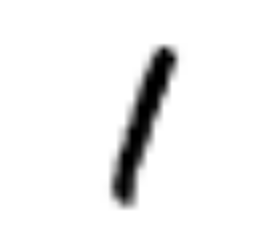

In [23]:
# Plot a random image
sample_number=5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred=gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

# Task: Create a network with MaxPooling

Typical convolutional networks have interlacing convolution and max pool layers. The previous model had only convolution layer. In this section, you will create a model with the following architecture.

![conv-only](https://www.cntk.ai/jup/cntk103d_conv_max.png)

You will use the CNTK [MaxPooling](https://cntk.ai/pythondocs/cntk.layers.layers.html#cntk.layers.layers.MaxPooling) function to achieve this task

In [24]:
# Modify this model
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(2,2), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(2,2), 
                                       pad=True, name='second_conv')(h)
            r = C.layers.Dense(num_output_classes, activation = None, name='classify')(h)
            return r
        
# do_train_test()

**Quiz**: How many parameters do we have in the model with MaxPooling and Convolution? Which of the two models produces lower error rate?


**Exploration Suggestion**
- Does use of LeakyRelu help improve the error rate?
- What percentage of the parameter does the last dense layer contribute w.r.t. the overall number of parameters for (a) purely two convolutional layer and (b) alternating 2 convolutional and maxpooling layers   

# Solution

In [25]:
# function to build model

def create_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(1,1), 
                                       pad=True, name="first_conv")(h)
            h = C.layers.MaxPooling(filter_shape=(2,2), 
                                    strides=(2,2), name="first_max")(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(1,1), 
                                       pad=True, name="second_conv")(h)
            h = C.layers.MaxPooling(filter_shape=(3,3), 
                                    strides=(3,3), name="second_max")(h)
            r = C.layers.Dense(num_output_classes, activation = None, name="classify")(h)
            return r
        
do_train_test()

Minibatch: 0, Loss: 2.3257, Error: 96.88%
Minibatch: 500, Loss: 0.0567, Error: 0.00%
Minibatch: 1000, Loss: 0.0877, Error: 3.12%
Minibatch: 1500, Loss: 0.1149, Error: 3.12%
Minibatch: 2000, Loss: 0.0063, Error: 0.00%
Minibatch: 2500, Loss: 0.0350, Error: 1.56%
Minibatch: 3000, Loss: 0.0037, Error: 0.00%
Minibatch: 3500, Loss: 0.1116, Error: 3.12%
Minibatch: 4000, Loss: 0.0037, Error: 0.00%
Minibatch: 4500, Loss: 0.0149, Error: 1.56%
Minibatch: 5000, Loss: 0.0385, Error: 1.56%
Minibatch: 5500, Loss: 0.0027, Error: 0.00%
Minibatch: 6000, Loss: 0.0130, Error: 0.00%
Minibatch: 6500, Loss: 0.0129, Error: 0.00%
Minibatch: 7000, Loss: 0.0061, Error: 0.00%
Minibatch: 7500, Loss: 0.0055, Error: 0.00%
Minibatch: 8000, Loss: 0.0157, Error: 0.00%
Minibatch: 8500, Loss: 0.0585, Error: 1.56%
Minibatch: 9000, Loss: 0.0153, Error: 1.56%
Training took 27.1 sec
Average test error: 1.10%
